In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#importanda dados
df = pd.read_csv("dados/dataset_problema2.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          132 non-null    int64  
 1   NDVI_d28    132 non-null    float64
 2   SAVI_d28    132 non-null    float64
 3   GNDVI_d28   132 non-null    float64
 4   MCARI1_d28  132 non-null    float64
 5   SR_d28      132 non-null    float64
 6   NDVI_d01    132 non-null    float64
 7   SAVI_d01    132 non-null    float64
 8   GNDVI_d01   132 non-null    float64
 9   MCARI1_d01  132 non-null    float64
 10  SR_d01      132 non-null    float64
 11  NDVI_d04    132 non-null    float64
 12  SAVI_d04    132 non-null    float64
 13  GNDVI_d04   132 non-null    float64
 14  MCARI1_d04  132 non-null    float64
 15  SR_d04      132 non-null    float64
 16  NDVI_d08    132 non-null    float64
 17  SAVI_d08    132 non-null    float64
 18  GNDVI_d08   132 non-null    float64
 19  MCARI1_d08  132 non-null    f

In [4]:
df

,id,NDVI_d28,SAVI_d28,GNDVI_d28,MCARI1_d28,SR_d28,NDVI_d01,SAVI_d01,GNDVI_d01,MCARI1_d01,SR_d01,NDVI_d04,SAVI_d04,GNDVI_d04,MCARI1_d04,SR_d04,NDVI_d08,SAVI_d08,GNDVI_d08,MCARI1_d08,SR_d08,Severidade
0,2,0.806955,1.210392,0.705323,19513.85630,10.557411,0.774359,1.161514,0.717367,30041.91766,8.531835,0.777758,1.166604,0.680269,22731.09954,8.380453,0.725521,1.088240,0.669113,16190.82038,6.491860,37.83
1,10,0.789403,1.184062,0.688353,17859.92417,9.527958,0.757559,1.136312,0.706716,26529.38283,7.888508,0.737634,1.106409,0.653475,17483.16681,7.039555,0.701538,1.052262,0.651048,13607.31327,5.889840,46.07
2,12,0.806006,1.208966,0.698522,18325.86796,10.450621,0.776762,1.165121,0.712256,35348.89095,8.872072,0.757991,1.136947,0.663469,18970.25945,7.691801,0.721819,1.082688,0.654506,16312.51025,6.385158,38.38
3,20,0.778408,1.167566,0.674224,16130.88569,9.135821,0.755313,1.132947,0.697300,30860.23050,7.873267,0.731638,1.097415,0.648051,15867.27075,6.888080,0.723709,1.085521,0.659776,15024.84460,6.503054,38.15
4,46,0.777937,1.166863,0.670604,17315.57673,8.797762,0.765304,1.147933,0.699105,30874.50847,8.130076,0.777302,1.165921,0.678815,23387.23253,8.498031,0.782553,1.173796,0.707183,22071.41814,8.726001,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,99,0.771956,1.157887,0.684271,15544.34528,8.793058,0.756874,1.135286,0.716099,29284.26304,7.874621,0.736759,1.105095,0.676929,15552.39493,7.002859,0.721953,1.082884,0.678242,13753.59426,6.400156,63.68
128,106,0.684094,1.026101,0.579705,14363.76139,5.485155,0.683368,1.025026,0.621754,21390.94521,5.440783,0.698290,1.047398,0.612533,15864.07369,5.836134,0.722138,1.083168,0.646372,16276.04763,6.535245,28.48
129,101,0.702853,1.054238,0.596766,14282.54195,6.243612,0.703867,1.055777,0.637277,23944.36106,6.083072,0.706356,1.059496,0.612366,16146.96220,6.102729,0.715297,1.072908,0.632440,16155.19752,6.366358,37.31
130,105,0.649085,0.973586,0.556922,12279.07652,4.789961,0.651537,0.977283,0.607133,21376.18619,4.800934,0.670120,1.005140,0.587082,13652.41571,5.173874,0.699264,1.048856,0.619211,14888.57394,5.873620,37.78


In [5]:
# Criando x e y
X = df.drop(['id', 'Severidade'], axis = 1)
y = df['Severidade']

In [6]:
# separar dados de treinamento e dados de teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [7]:
#padronizando os dados
# objetivo aqui é retirar o impacto numérico das features. 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #media 0 e desvio padrão 1
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
#recuperando nomes colunas
X_train_sc = pd.DataFrame(X_train_sc)
X_train_sc.columns = X_train.columns

X_test_sc = pd.DataFrame(X_test_sc)
X_test_sc.columns = X_test.columns


In [8]:
X_train_sc.columns.size

20

In [12]:
#otimização de hiperparametros - considerando todas as colunas. 
from skopt import gp_minimize
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def treinar_modelo(parametros):
    model_rf = RandomForestRegressor(criterion=parametros[0], 
                                      n_estimators=parametros[1], 
                                      max_depth=parametros[2], 
                                      min_samples_split=parametros[3], 
                                      min_samples_leaf=parametros[4], 
                                      random_state=0, n_jobs=-1)
    score = cross_val_score(model_rf,X_train_sc,y_train,cv=10)
    meanscore = np.mean(score)
    print(np.mean(score))
    #quanto maior melhor
    return -meanscore
    
#tuplas com os parametros
parametros = [('absolute_error', 'squared_error'),#criterion
              (500, 2000), # n_estimators
              (15,30), #max_depth
              (8,20), # min_samples_split
              (1,10)] # min_samples_leaf
otimos = gp_minimize(treinar_modelo, parametros, random_state=0, verbose=1,n_calls=20, 
                     n_random_starts=10);

Iteration No: 1 started. Evaluating function at random point.
0.836387789611363
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 19.8237
Function value obtained: -0.8364
Current minimum: -0.8364
Iteration No: 2 started. Evaluating function at random point.
0.8478196397839854
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 11.8339
Function value obtained: -0.8478
Current minimum: -0.8478
Iteration No: 3 started. Evaluating function at random point.
0.8403208819202076
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 13.8856
Function value obtained: -0.8403
Current minimum: -0.8478
Iteration No: 4 started. Evaluating function at random point.
0.8266653274280852
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 13.0691
Function value obtained: -0.8267
Current minimum: -0.8478
Iteration No: 5 started. Evaluating function at random point.
0.8431960056926661
Iteration No: 5 ended. Evaluation done at random point.
Time

In [13]:
# imprimindo o melhor resultado
otimos.fun, otimos.x

(np.float64(-0.8556763437269377),
 [np.str_('absolute_error'),
  np.int64(2000),
  np.int64(15),
  np.int64(8),
  np.int64(1)])

In [16]:
# treinando modelo final  com os melhores parametros
model_rf = RandomForestRegressor(criterion=otimos.x[0], 
                                      n_estimators=otimos.x[1], 
                                      max_depth=otimos.x[2], 
                                      min_samples_split=otimos.x[3], 
                                      min_samples_leaf=otimos.x[4], 
                                      random_state=0, n_jobs=-1)

model_rf.fit(X_train_sc,y_train)
y_pred = model_rf.predict(X_train_sc)
train_score = model_rf.score(X_train_sc,y_train)
test_score = model_rf.score(X_test_sc,y_test)
print(f"Train score: {train_score}, Test score: {test_score}")

Train score: 0.9712281290917159, Test score: 0.8991268917757441


In [18]:
# Com base nisso, agora iremos averiguar se realmente precisamos de todas as 20 features 
# Vamos selecionar as mais importantes
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
max_f = X_train_sc.columns.size + 1
lista_score = list()
for i in range(1,max_f):
    modelo_rf = RandomForestRegressor(criterion=otimos.x[0], 
                                      n_estimators=otimos.x[1], 
                                      max_depth=otimos.x[2], 
                                      min_samples_split=otimos.x[3], 
                                      min_samples_leaf=otimos.x[4], 
                                      random_state=0, n_jobs=-1)
    selector = RFE(modelo_rf, n_features_to_select=i,step=1)
    selector = selector.fit(X_train_sc,y_train)
    mask = selector.support_
    mask
    features = X_train_sc.columns
    
    sel_features = features[mask]
    #print(sel_features)
    # pegando somente as duas features
    X_sel = X_train_sc[sel_features]
    
    score = cross_val_score(modelo_rf, X_sel, y_train, cv=10, scoring='r2')
    print(f"{i} features - {np.mean(score)}")
    lista_score.append(np.mean(score))

1 features - 0.6677177376449921
2 features - 0.7718939605634496
3 features - 0.7785415451342503
4 features - 0.848212554435063
5 features - 0.8524158748865233
6 features - 0.851939931253424
7 features - 0.8558208878164051
8 features - 0.8541844856602742
9 features - 0.8606544090059447
10 features - 0.8608596758408776
11 features - 0.8566693238186535
12 features - 0.8586390852729512
13 features - 0.8586499212301708
14 features - 0.859783201026602
15 features - 0.8580834620959278
16 features - 0.8580829138637862
17 features - 0.8575117974697404
18 features - 0.8567667732826427
19 features - 0.856076669130795
20 features - 0.8556763437269378


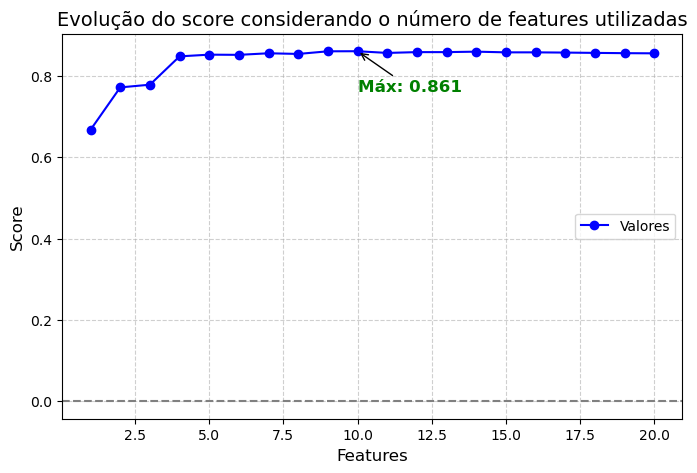

In [27]:
# gráfico
# 10 features é o melhor
import matplotlib.pyplot as plt

x = np.arange(len(lista_score))
x = x + 1
max_index = np.argmax(lista_score) + 1
max_value = lista_score[max_index-1]
# Criando o gráfico
plt.figure(figsize=(8, 5))
plt.plot(x, lista_score, marker='o', linestyle='-', color='b', markersize=6, label="Valores")

# Adicionando título e rótulos
plt.title("Evolução do score considerando o número de features utilizadas", fontsize=14)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.axhline(y=0, color='gray', linestyle="--")  # Linha no zero para referência
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Adicionando a seta no maior valor
plt.annotate(
    f"Máx: {max_value:.3f}",  # Texto exibindo o valor máximo
    xy=(max_index, max_value),  # Posição do maior valor
    xytext=(max_index, max_value - 0.1),  # Posição do texto
    arrowprops=dict(facecolor='red', arrowstyle="->"),  # Estilo da seta
    fontsize=12, color='green', fontweight="bold")

#salvando o gráfico
plt.savefig("features_randomforest.png", dpi=300)  # Salva em PNG
# Exibir o gráfico
plt.show()

In [21]:
# seleção final das 10 features
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
modelo_rf = RandomForestRegressor(criterion=otimos.x[0], 
                                  n_estimators=otimos.x[1], 
                                  max_depth=otimos.x[2], 
                                  min_samples_split=otimos.x[3], 
                                  min_samples_leaf=otimos.x[4], 
                                  random_state=0, n_jobs=-1)
selector = RFE(modelo_rf, n_features_to_select=10,step=1)
selector = selector.fit(X_train_sc,y_train)
mask = selector.support_
mask
features = X_train_sc.columns

sel_features = features[mask]
#print(sel_features)
# pegando somente as features selecionadas
X_sel = X_train_sc[sel_features]

score = cross_val_score(modelo_rf, X_sel, y_train, cv=10, scoring='r2')
print(np.mean(score))

0.8608596758408776


In [23]:
#modelo final
modelo_final = RandomForestRegressor(criterion=otimos.x[0], 
                                      n_estimators=otimos.x[1], 
                                      max_depth=otimos.x[2], 
                                      min_samples_split=otimos.x[3], 
                                      min_samples_leaf=otimos.x[4], 
                                      random_state=0, n_jobs=-1)

modelo_final.fit(X_sel,y_train)
y_pred = modelo_final.predict(X_sel)
train_score = modelo_final.score(X_sel,y_train)
test_score = modelo_final.score(X_test_sc[sel_features],y_test)
print(f"Test score: {test_score}")

Test score: 0.9036117310856485


In [24]:
# testar nos dados de teste

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_pred = modelo_final.predict(X_test_sc[sel_features])

r2 = modelo_final.score(X_test_sc[sel_features], y_test)

rmse = (mean_squared_error(y_test, y_pred)**0.5)

mae = mean_absolute_error(y_test, y_pred)

print('r2', r2)
print('rmse', rmse)
print('mae', mae)

r2 0.9036117310856485
rmse 6.98290822085366
mae 6.207452314814821
